### Download codebase and compile extensions

In [1]:
%bookmark HOME
# !git clone https://github.com/facebookresearch/goliath.git
%cd goliath

/mnt/home/julietamartinez/goliath


In [2]:
%bookmark GOLIATH_HOME

Compile goliath extensions for ray marching, Gaussian splatting, etc
This migth take 2-3 minutes on a free colab server

In [3]:
# %%time
# %%capture
# for ext in ["mvpraymarch", "sgutils", "utils"]:
#     %cd GOLIATH_HOME
#     %cd 'extensions/{ext}'
#     !make;
# %cd GOLIATH_HOME

There are four subjects in Goliath:
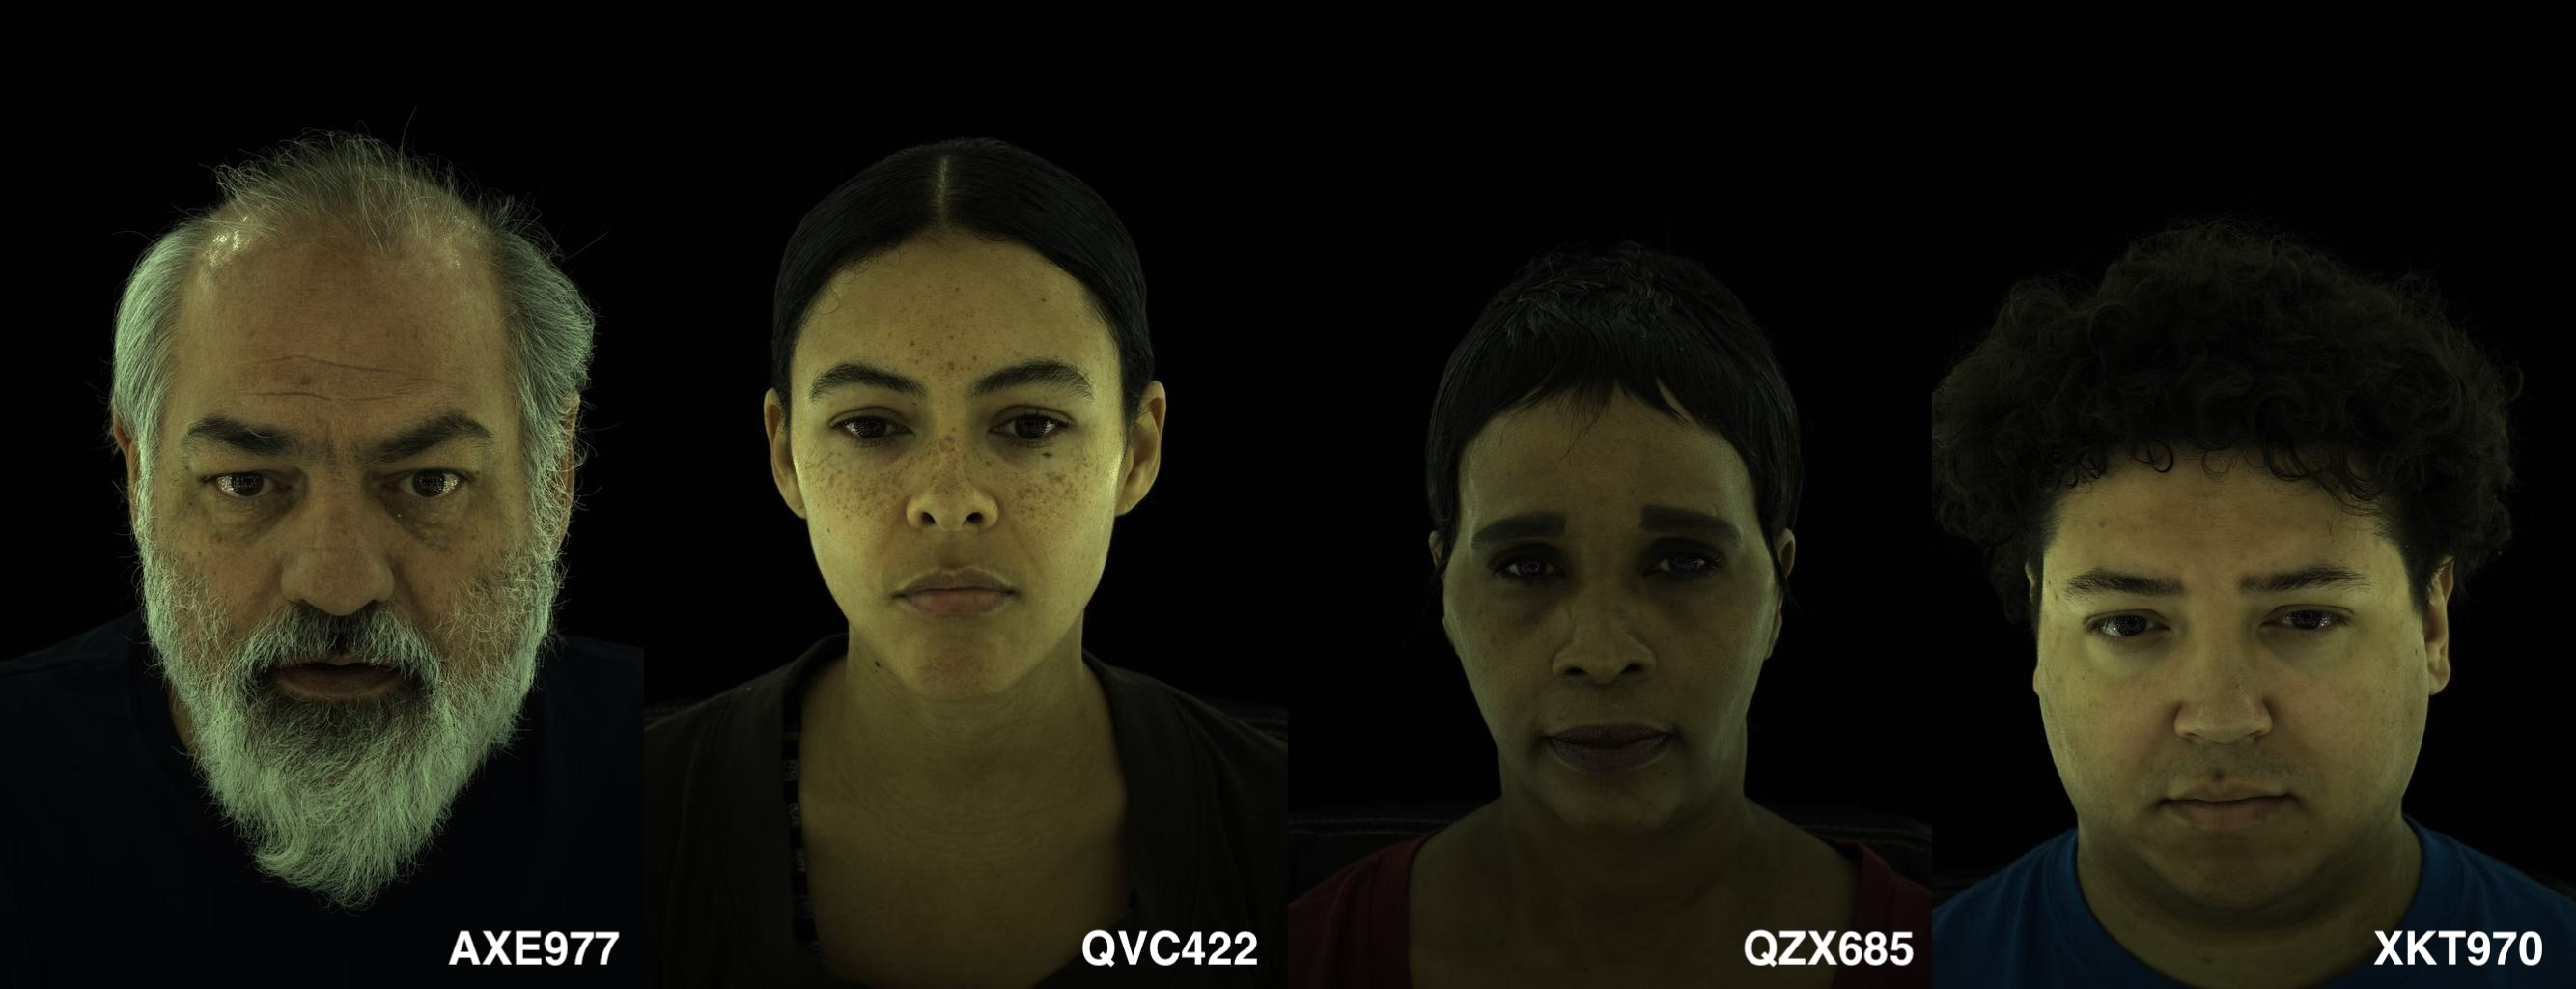

Download a checkpoint for AXE977 and demo relightable splatting (2.2 GiB)

In [4]:
# !mkdir -p checkpoints/RGCA/AXE977
# !wget https://fb-baas-f32eacb9-8abb-11eb-b2b8-4857dd089e15.s3.amazonaws.com/goliath-for-review-full/checkpoints/RGCA/AXE977/790000.pt -O checkpoints/RGCA/AXE977/790000.pt

Download 100 frames of sample data (2.0 GiB)

In [5]:
# !mkdir -p data/RGCA/AXE977
# !wget https://fb-baas-f32eacb9-8abb-11eb-b2b8-4857dd089e15.s3.amazonaws.com/goliath-for-review-100frames/m--20230306--0707--AXE977--pilot--ProjectGoliath--Head--100frames.zip -O data/RGCA/AXE977/m--20230306--0707--AXE977--pilot--ProjectGoliath--Head--100frames.zip
# !unzip -P RLR-2015-2024 data/RGCA/AXE977/m--20230306--0707--AXE977--pilot--ProjectGoliath--Head--100frames.zip -d data/RGCA/AXE977/

We also need some shared assets like the head topology (694 MiB)

In [6]:
# !wget https://fb-baas-f32eacb9-8abb-11eb-b2b8-4857dd089e15.s3.amazonaws.com/goliath-for-review-full/shared.zip -O data/shared.zip
# unzip -P RLR-2015-2024 data/shared.zip -d data/
# TODO(julieta) remove zip?

In [7]:
# TODO(julieta) add some visualizations of the data here...

In [8]:
# Load a pre-built config, it will make things easier
from omegaconf import DictConfig, OmegaConf
from ca_code.utils.dataloader import BodyDataset, collate_fn
from torch.utils.data import DataLoader

config = OmegaConf.load("config/rgca_example.yml")

# Create the dataset that we will use
config.data.root_path = "data/RGCA/AXE977/m--20230306--0707--AXE977--pilot--ProjectGoliath--Head--100frames/"
config.data.shared_assets_path = "data/shared/static_assets_head.pt"
config.data.split = "test"
config.data.fully_lit_only = True
config.data.partially_lit_only = False
# config.data.frames_subset = config.test.data.frames_subset

dataset = BodyDataset(**config.data)

config.dataloader.shuffle = False
config.dataloader.batch_size = 1
config.dataloader.num_workers = 4

dataset.cameras = ["401892"]
loader = DataLoader(dataset, collate_fn=collate_fn, **config.dataloader)

In [9]:
dataset.frames_subset

set()

In [10]:
len(dataset)

2

In [11]:
# Create model, load weights
from addict import Dict as AttrDict
from ca_code.utils.module_loader import load_from_config
from ca_code.utils.train import load_checkpoint, to_device

ckpt_path = "checkpoints/RGCA/AXE977/790000.pt"

static_assets = AttrDict(dataset.static_assets)

device = "cuda"
model = (
        load_from_config(
            config.model,
            assets=static_assets,
        )
        .to(device)
        .eval()
    )
# loading model checkpoint
load_checkpoint(ckpt_path, modules={"model": model}, strict=False)

/mnt/home/julietamartinez/goliath/ca_code/utils/dataloader.py:119: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(self.shared_assets_path, map_location="cpu

In [12]:
from ca_code.utils.light_decorator import EnvSpinDecorator, SingleLightCycleDecorator

# disabling training-only stuff
model.learn_blur_enabled = False
model.cal_enabled = False

model_p = SingleLightCycleDecorator(model, light_rotate_axis=1).to(device)

In [13]:
!mkdir -p preds/

In [14]:
from torchvision.utils import make_grid, save_image
from ca_code.utils.image import linear2srgb
import torch as th

batch_filter_fn = dataset.batch_filter

# forward
for i, batch in enumerate(loader):
    print(f"{i}/{len(loader)}")
    batch = to_device(batch, device)
    batch_filter_fn(batch)

    with th.no_grad():
        preds = model_p(**batch, index=[180 + i])

    # visualizing
    rgb_preds_grid = make_grid(linear2srgb(preds["rgb"]), nrow=4)
    save_image(rgb_preds_grid, f"preds/{i}.png")

0/2
1/2


# Do inference, show viz

In [15]:
# from IPython.display import Image
# Image(filename='preds/0.png') 

In [16]:
# Image(filename='preds/1.png') 

'/mnt/home/julietamartinez/goliath'